In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

from IPython.display import clear_output

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

In [2]:
# tf.config.run_functions_eagerly(True)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
def preprocess_images(images):
    return images.astype("float32") / 255.

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

In [5]:
train_size = len(X_train)
batch_size = 32
test_size = len(X_test)

In [6]:
print(X_train.shape, y_train.shape)
print(tf.reduce_min(X_train))
print(tf.reduce_max(X_train))
print(tf.reduce_min(y_train))
print(tf.reduce_max(y_train))

(50000, 32, 32, 3) (50000, 1)


2022-09-28 22:44:07.980559: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 22:44:08.421033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22309 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(9, shape=(), dtype=uint8)


In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test)
                .shuffle(test_size).batch(batch_size))

In [8]:
# X_val = X_train[-10000:]
# y_val = y_train[-10000:]
# X_train = X_train[:-10000]
# y_train = y_train[:-10000]

In [9]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "variational_autoencoder")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [10]:
# adapted from https://www.tensorflow.org/tutorials/generative/cvae#network_architecture
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=4*4*128, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(4, 4, 128)),
                tf.keras.layers.Conv2DTranspose(
                    filters=96, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)
    
    def compute_loss(self, x, y=None, y_pred=None, sample_weight=None):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_pred = self.decode(z, apply_sigmoid=True)
        logpx_z = self.log_normal_pdf(x_pred, x, -5.991464547107982, raxis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    def train_step(self, x):
        """Executes one training step and returns the loss.
        
        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}
    
    def test_step(self, x):
        return {"loss": self.compute_loss(x)}
    
    
    def call(self, inputs, training=None, mask=None):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, apply_sigmoid=True)

In [11]:
cvae = CVAE(30)
cvae.compile(optimizer="adam")
cvae.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=500,
    callbacks=[
        get_tensorboard_cb(), 
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ])

Epoch 1/500


2022-09-28 22:44:14.204390: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-09-28 22:44:14.799691: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 22:44:14.800727: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 22:44:14.800787: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-28 22:44:14.802031: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 22:44:14.802129: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-28 22:44:15.312123: I tensorflow/stream_executor/cuda/c

1563/1563 [==============================] - 19s 11ms/step - loss: 6891.0590 - val_loss: 1968.7703
Epoch 2/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1797.0510 - val_loss: 2846.6089
Epoch 3/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1572.3348 - val_loss: -170.3955
Epoch 4/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1410.8089 - val_loss: 2155.5007
Epoch 5/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1292.7707 - val_loss: 1376.8860
Epoch 6/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1223.0880 - val_loss: 464.5258
Epoch 7/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1162.3306 - val_loss: 1149.1185
Epoch 8/500
1563/1563 [==============================] - 17s 11ms/step - loss: 1118.3688 - val_loss: 2420.2874


In [12]:
def display_samples(samples):
    n = len(samples)
    c = 10
    r = n // c
    fig, axs = plt.subplots(r, c, figsize=(20, 20))
    for i in range(samples.shape[0]):
        ri = i // c
        ci = i % c
        axs[ri, ci].imshow(samples[i])

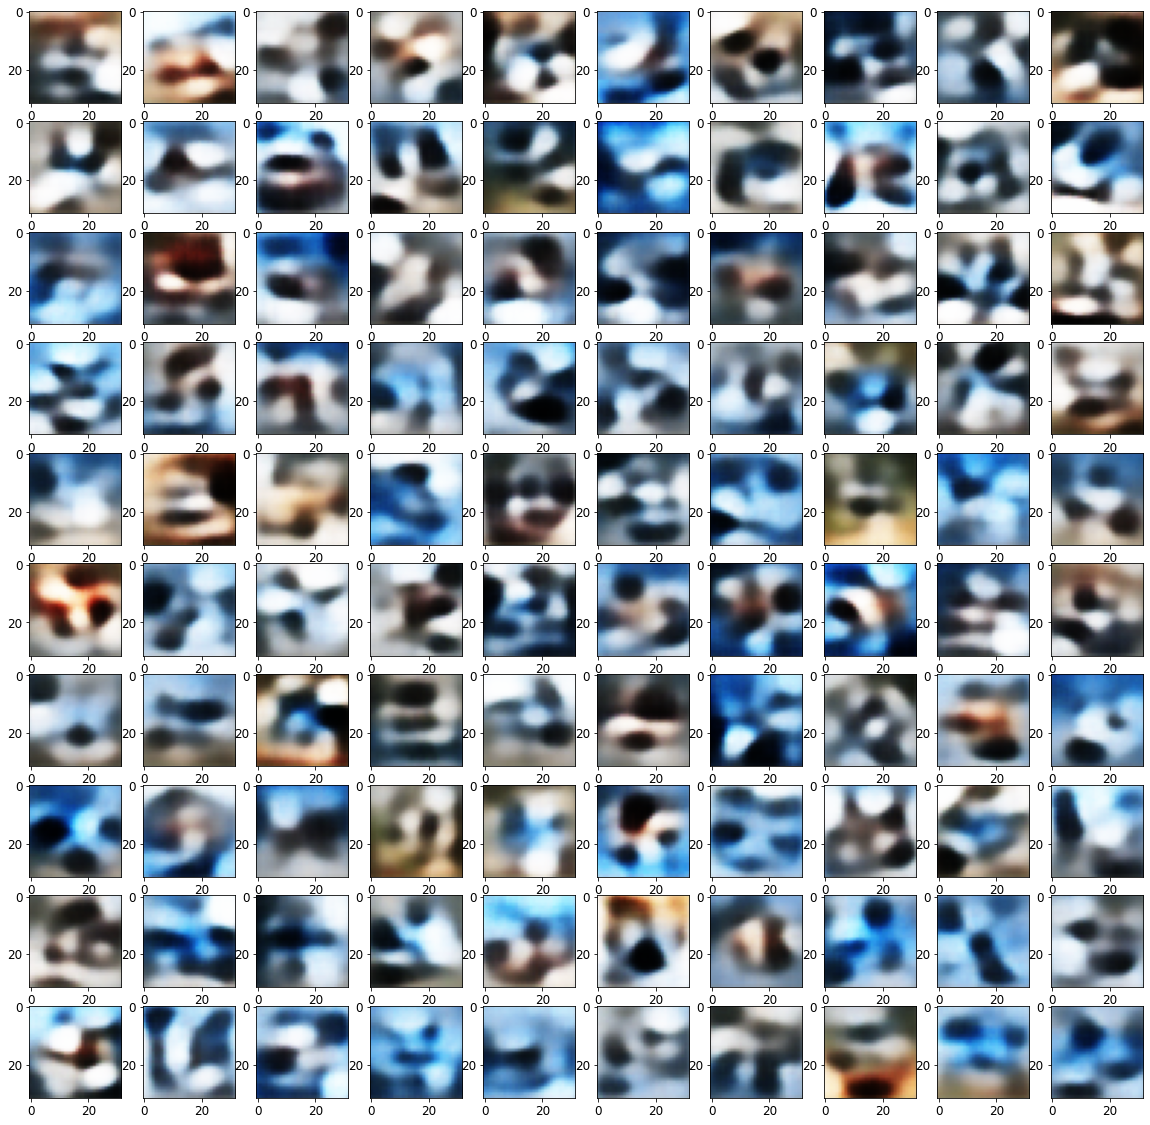

In [13]:
samples = cvae.sample().numpy()
display_samples(samples)

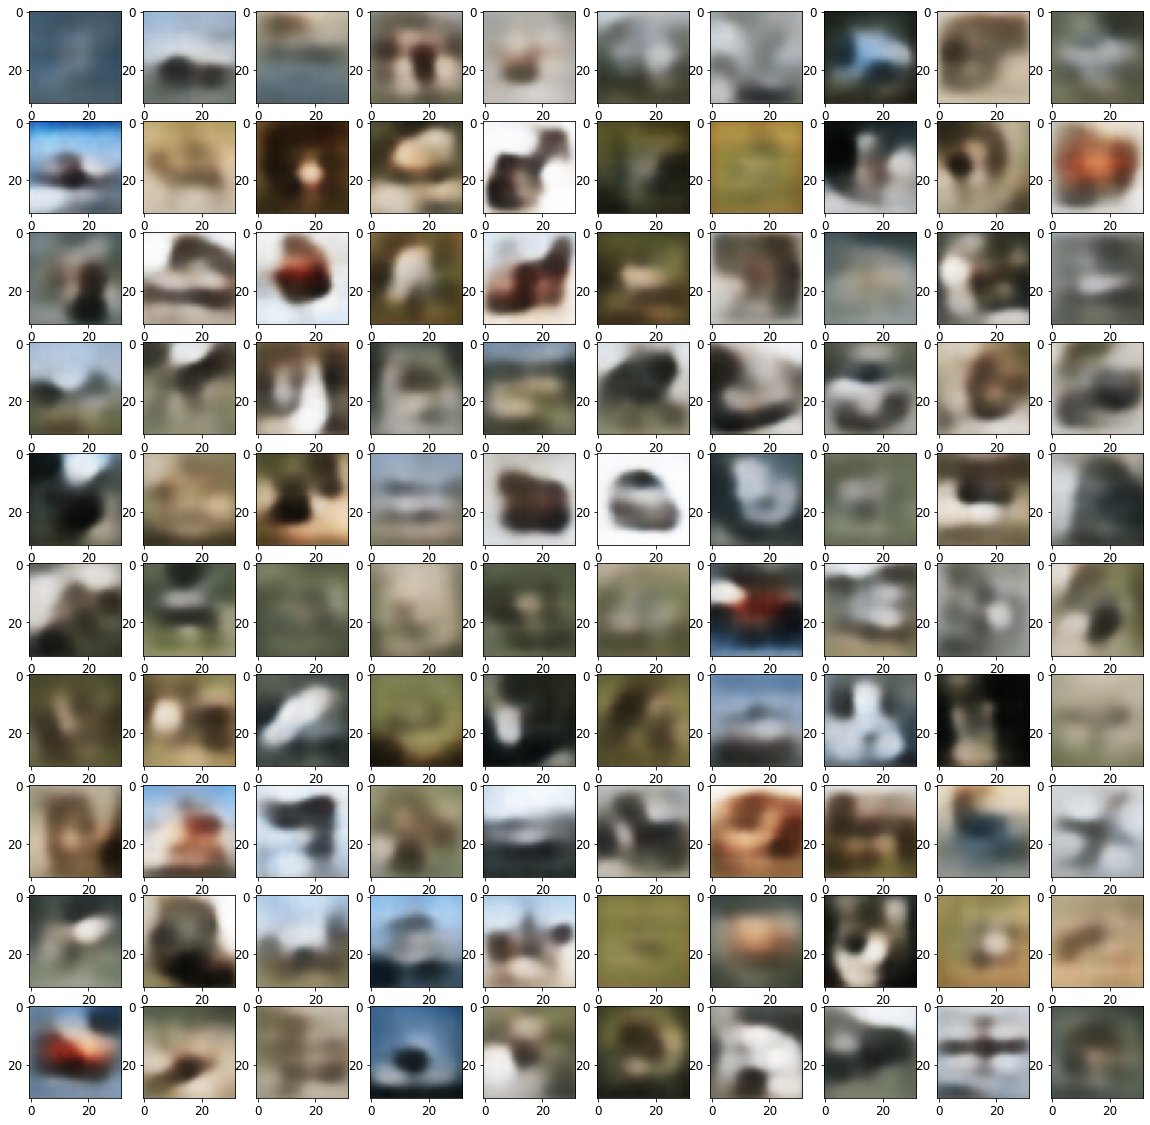

In [14]:
dataset_sample = next(iter(test_dataset.unbatch().batch(100).take(1)))
conditional_samples = cvae(dataset_sample)
display_samples(conditional_samples)